In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

In [5]:
df_reservations= pd.read_csv("../data/01_raw/reservations.csv")
df_reservations.head()

,vehicle_id,created_at
0,208,2023-07-27 14:58:26
1,601,2023-04-18 09:36:57
2,993,2023-12-25 01:22:09
3,423,2023-07-26 04:54:19
4,685,2023-11-26 15:21:35


In [6]:
df_reservations.info()
df_reservations.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vehicle_id  6376 non-null   int64 
 1   created_at  6376 non-null   object
dtypes: int64(1), object(1)
memory usage: 99.8+ KB


,vehicle_id
count,6376.000000
mean,500.131901
std,292.792987
min,1.000000
25%,248.000000
50%,500.000000
75%,749.000000
max,1000.000000


In [7]:
# Group the DataFrame of 'reservations' by the 'vehicle_id' column and count the number of reservations for each vehicle, so we get our target column.

df_reservations_count = df_reservations.groupby('vehicle_id').size().reset_index(name='reservations')
df_reservations_count

,vehicle_id,reservations
0,1,1
1,2,7
2,3,17
3,4,2
4,5,2
...,...,...
906,996,19
907,997,9
908,998,6
909,999,9


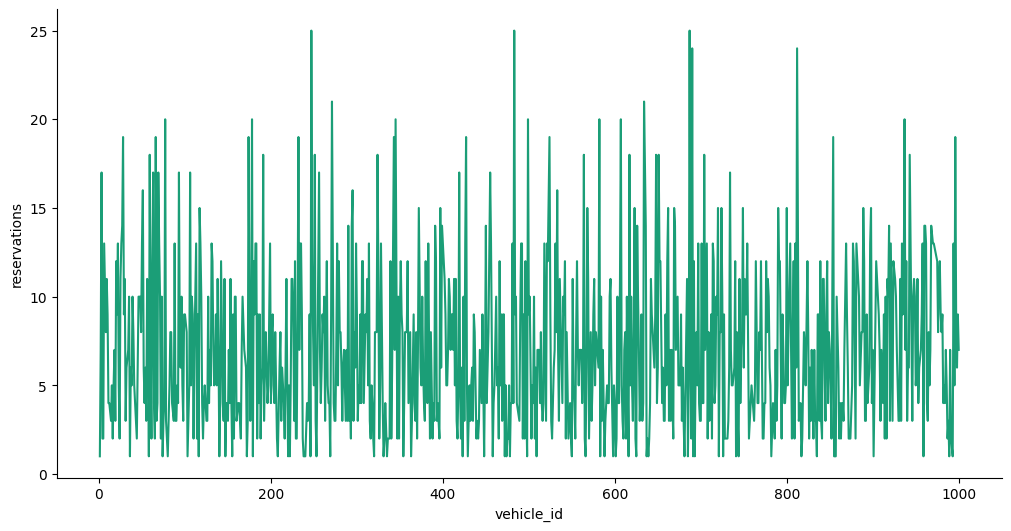

In [8]:
#Plot the distribution of reservations per vehicle
def _plot_series(series, series_name,x,y, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[x]
  ys = series[y]

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_reservations_count.sort_values('vehicle_id', ascending=True)
_plot_series(df_sorted, '','vehicle_id','reservations')
sns.despine(fig=fig, ax=ax)
plt.xlabel('vehicle_id')
_ = plt.ylabel('reservations')

In [9]:
df_vehicles= pd.read_csv("../data/01_raw/vehicles.csv")
df_vehicles.head()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description
0,1,1,67.85,59,5,0,7
1,2,0,100.70,53,5,0,224
2,3,0,74.00,74,4,1,21
3,4,0,135.00,75,1,0,184
4,5,0,59.36,53,2,1,31


In [10]:
df_vehicles.info()
df_vehicles.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vehicle_id         1000 non-null   int64  
 1   technology         1000 non-null   int64  
 2   actual_price       1000 non-null   float64
 3   recommended_price  1000 non-null   int64  
 4   num_images         1000 non-null   int64  
 5   street_parked      1000 non-null   int64  
 6   description        1000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 54.8 KB


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000


In [11]:
# CHeck if there is duplicated vehicle_id
has_duplicated = df_vehicles['vehicle_id'].duplicated().any()
has_duplicated

False

In [12]:
# Merge the datasets by doing a left join on vehicles (cause there are vehicles without reservations)
df = pd.merge(df_vehicles, df_reservations_count, on='vehicle_id', how='left')
df.head()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reservations
0,1,1,67.85,59,5,0,7,1.0
1,2,0,100.70,53,5,0,224,7.0
2,3,0,74.00,74,4,1,21,17.0
3,4,0,135.00,75,1,0,184,2.0
4,5,0,59.36,53,2,1,31,2.0


In [13]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vehicle_id         1000 non-null   int64  
 1   technology         1000 non-null   int64  
 2   actual_price       1000 non-null   float64
 3   recommended_price  1000 non-null   int64  
 4   num_images         1000 non-null   int64  
 5   street_parked      1000 non-null   int64  
 6   description        1000 non-null   int64  
 7   reservations       911 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reservations
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,911.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,6.998902
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,4.645333
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,1.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,3.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,6.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,10.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,25.000000


In [14]:
#Check if there are vehicles without reservations
vehicules_without_reservations = df[df['reservations'].isnull()]
vehicules_without_reservations

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reservations
6,7,0,165.17,83,3,0,32,NaN
12,13,0,109.80,60,1,0,40,NaN
32,33,0,126.06,66,1,0,97,NaN
44,45,0,115.71,87,2,0,20,NaN
85,86,0,103.32,84,3,1,239,NaN
...,...,...,...,...,...,...,...,...
968,969,0,78.09,57,1,1,125,NaN
971,972,0,91.28,56,1,0,13,NaN
972,973,0,94.40,80,1,1,167,NaN
973,974,0,88.56,54,1,1,42,NaN


In [15]:
#Set number of reservations for the vehicles without reservations to 0
df.fillna(0, inplace=True)
df.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,reservations
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,6.376000
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,4.861302
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,3.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,5.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,9.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,25.000000


In [16]:
#Cast the type of columnn 'reservations' to int

df['reservations'] = df['reservations'].astype(int)
reservations_count = df['reservations'].value_counts().sort_values()
reservations_count

reservations
24     2
21     2
25     3
16     3
20     7
17     9
19     9
18    10
15    14
14    14
11    36
13    45
12    45
10    45
6     53
8     57
1     61
7     62
9     65
5     87
0     89
2     89
4     96
3     97
Name: count, dtype: int64

In [17]:
# To prevent imbalanced classes during splitting, drop vehicles with fewer than 7 reservations.
# Drop vehicles_id column (we don't need it for training)

df = df[df['reservations'].map(reservations_count) > 7]
df.drop('vehicle_id', axis=1, inplace=True)

<Axes: >

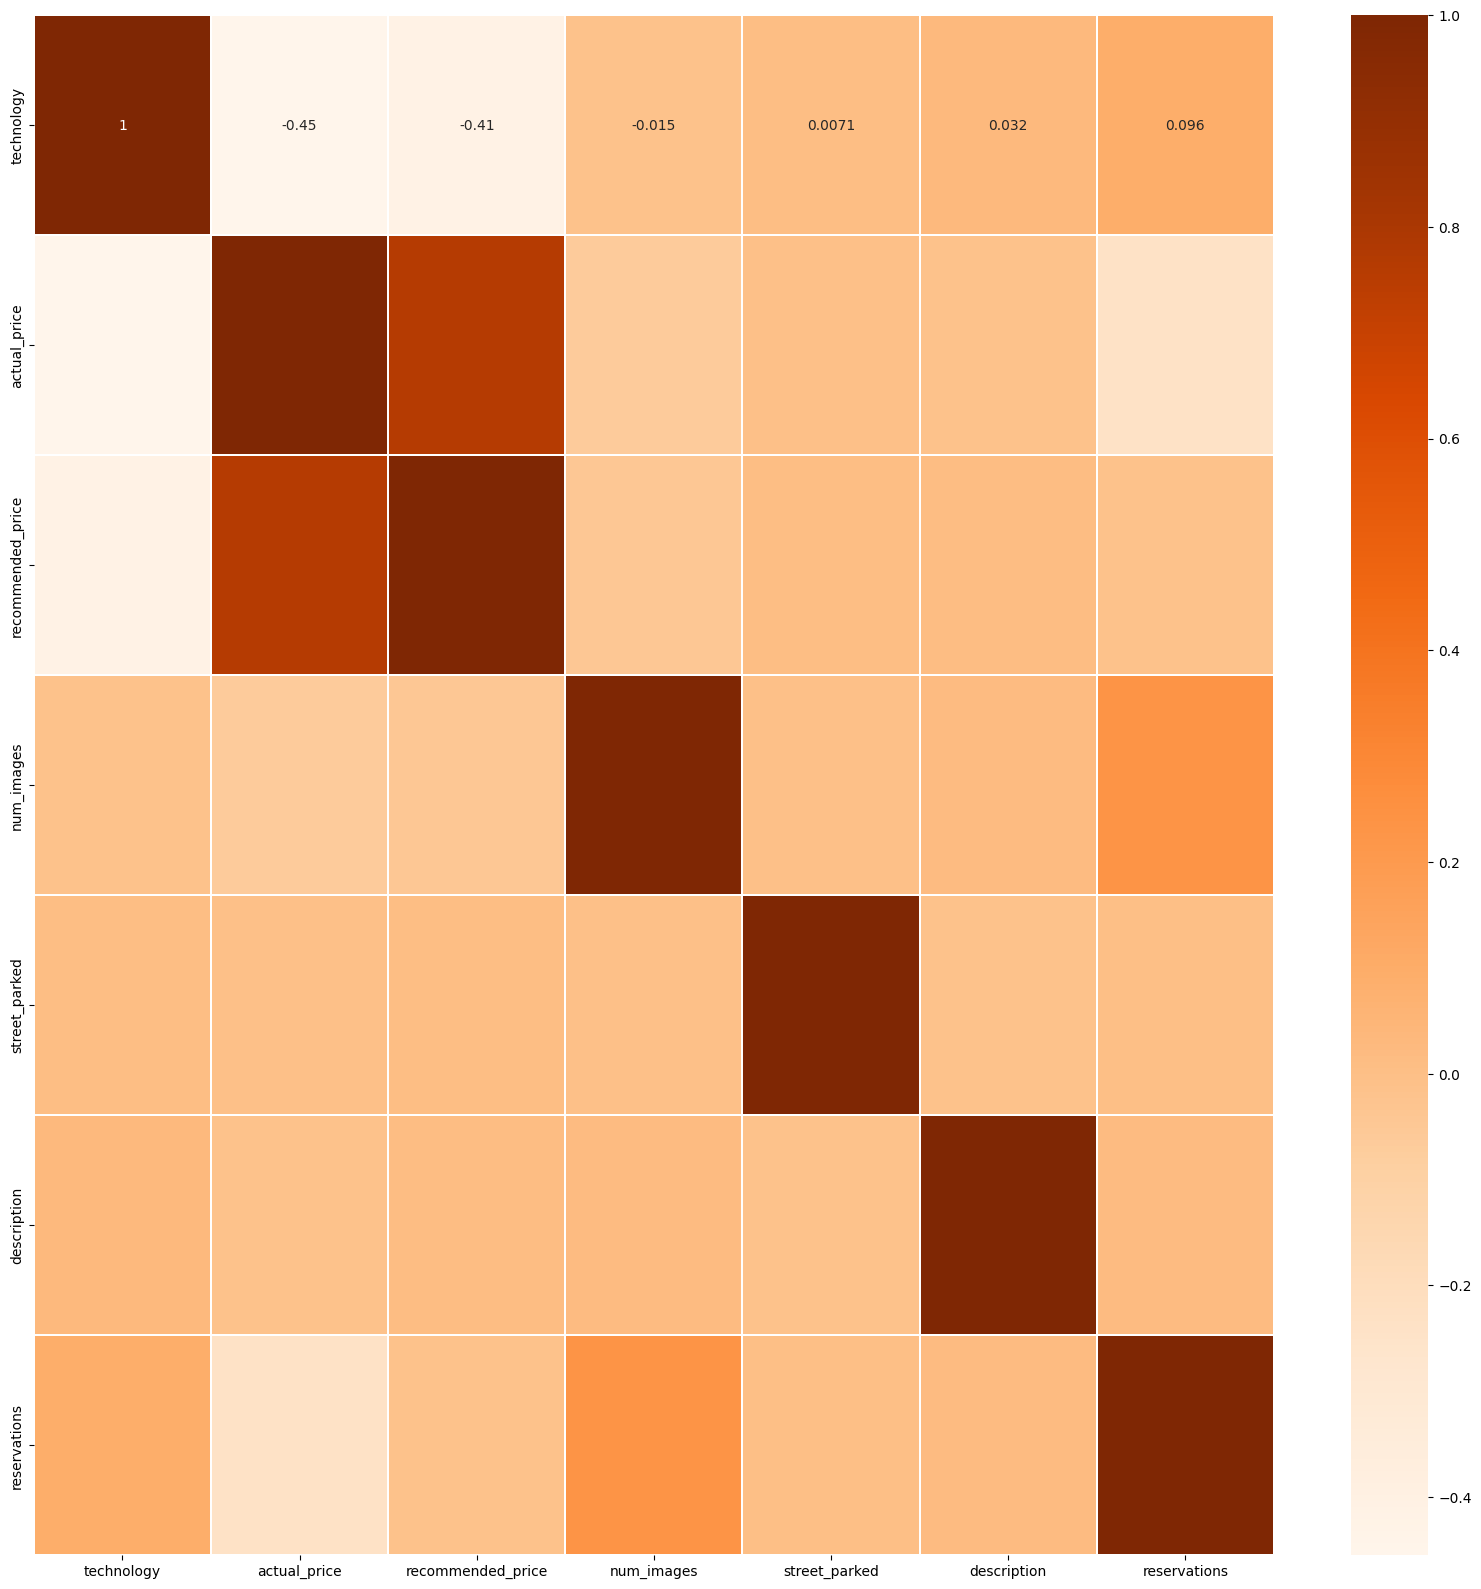

In [18]:
# Plot the correlation_matrix to understannd the linear relationship between variables
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.01, cmap= 'Oranges')

In [19]:
X = df.drop(['reservations'], axis=1)
Y = df['reservations']

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
# Split the data into train, test, and validation sets
train_size = 0.7
test_size = 0.15
validation_size = 0.15

# Initialize StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=validation_size + test_size, random_state=42)

# Split the data into training and remaining data
for train_index, remaining_index in stratified_split.split(X, Y):
    X_train, X_remaining = X.iloc[train_index], X.iloc[remaining_index]
    y_train, y_remaining = Y.iloc[train_index], Y.iloc[remaining_index]

# Initialize another StratifiedShuffleSplit for splitting the remaining data into validation and test sets
stratified_split_remaining = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (validation_size + test_size), random_state=42)

# Split the remaining data into validation and test sets
for validation_index, test_index in stratified_split_remaining.split(X_remaining, y_remaining):
    X_valid, X_test = X_remaining.iloc[validation_index], X_remaining.iloc[test_index]
    y_valid, y_test = y_remaining.iloc[validation_index], y_remaining.iloc[test_index]

In [21]:
print(X_train.shape, y_train.shape)

(688, 6) (688,)


**First attempt**

In [22]:
# We choose to train our first models to have a base line using some regressors {'Linear Regression', 'Decision Tree', 'Random Forest',
# 'XG Boost', 'Polynomial Reg', 'Ridge', 'Lasso', 'GBR'}


pipe_lr = Pipeline([('regressor', LinearRegression())])

pipe_dt = Pipeline([('regressor', DecisionTreeRegressor())])

pipe_rf = Pipeline([('regressor', RandomForestRegressor(n_jobs=-1))])

pipe_xgb = Pipeline([('regressor', XGBRegressor(objective= 'reg:absoluteerror',n_jobs=-1))])

pipe_polyReg = Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression())])

pipe_ridge = Pipeline([('regressor', Ridge())])

pipe_lasso = Pipeline([('regressor', Lasso())])
pipe_gbr = Pipeline([('regressor', GradientBoostingRegressor())])

pipelines = [pipe_lr, pipe_dt, pipe_rf, pipe_xgb, pipe_polyReg,pipe_ridge,pipe_lasso,pipe_gbr]
pipe_dict = {0: 'Linear Regression', 1: 'Decision Tree',
             2: 'Random Forest', 3: 'XG Boost',4: 'Polynomial Reg', 5:'Ridge', 6:'Lasso',7:'GBR'}

scoring = {
  'mse': make_scorer(mean_squared_error),
  'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
  'mae': make_scorer(mean_absolute_error),
  'r2': make_scorer(r2_score)}

results=[]
sfKFold = model_selection.StratifiedKFold(shuffle=True, random_state=0)

for idx, pipe in enumerate(pipelines):

    cv = model_selection.cross_validate(pipe, X_train, y_train, cv=sfKFold, scoring=scoring)
    results.append(cv)

    # Print the results
    print('------------------------------------------------------------------------------')
    print('Model:',pipe_dict[idx])
    print('------------------------------------------------------------------------------')
    print('mse  %.3f (%.3f) ' % (cv['test_mse'].mean(),cv['test_mse'].std()))
    print('rmse %.3f (%.3f) ' % (cv['test_rmse'].mean(),cv['test_rmse'].std()))
    print('mae  %.3f (%.3f) ' % (cv['test_mae'].mean(),cv['test_mae'].std()))
    print('r2   %.3f (%.3f) ' % (cv['test_r2'].mean(),cv['test_r2'].std()))

------------------------------------------------------------------------------
Model: Linear Regression
------------------------------------------------------------------------------
mse  17.439 (0.582) 
rmse 4.175 (0.069) 
mae  3.406 (0.048) 
r2   0.135 (0.040) 
------------------------------------------------------------------------------
Model: Decision Tree
------------------------------------------------------------------------------
mse  34.232 (2.163) 
rmse 5.848 (0.181) 
mae  4.586 (0.148) 
r2   -0.699 (0.140) 
------------------------------------------------------------------------------
Model: Random Forest
------------------------------------------------------------------------------
mse  18.468 (1.454) 
rmse 4.294 (0.168) 
mae  3.460 (0.172) 
r2   0.084 (0.085) 
------------------------------------------------------------------------------
Model: XG Boost
------------------------------------------------------------------------------
mse  20.654 (1.930) 
rmse 4.540 (0.211) 


In [23]:
model_perf = []
for idx,scores in enumerate(results):
    model_perf.append([pipe_dict[idx],'MSE',scores['test_mse'].mean()])
    model_perf.append([pipe_dict[idx],'RMSE',scores['test_rmse'].mean()])
    model_perf.append([pipe_dict[idx],'MAE',scores['test_mae'].mean()])
    model_perf.append([pipe_dict[idx],'R2',scores['test_r2'].mean()])



model_perf = pd.DataFrame(model_perf, columns=["Models", "Metrics","Scores"])

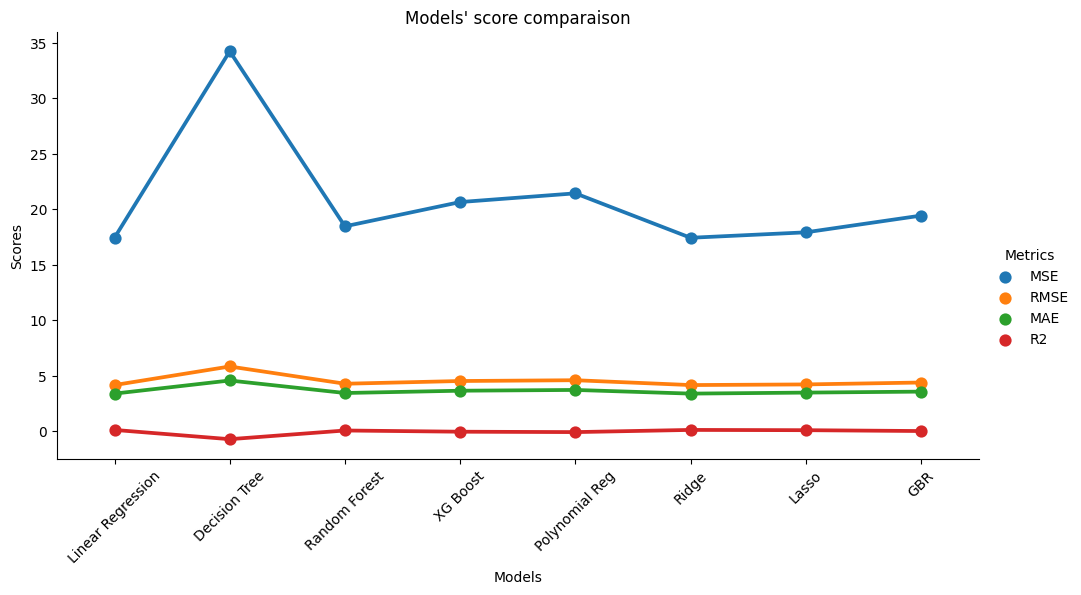

In [24]:
sns.catplot(data=model_perf, x="Models", y="Scores", hue="Metrics", kind="point", height=5, aspect=2)
plt.title("Models' score comparaison")
plt.xticks(rotation=45)
plt.show()

**Models Fine-tuning with Grid Search**

In [25]:
def GridSearch(X,Y,X_valid,y_valid):
  param_range = list(range(5,10))

  grid_params_rf = [{'regressor__criterion': ['absolute_error', 'squared_error','friedman_mse', 'poisson'],
                      'regressor__n_estimators': range(50,500,50)}]

  grid_params_xgb = [{'regressor__n_estimators': range(50,500,50),'regressor__learning_rate':[0.001, 0.01, 0.1]}]

  grid_params_ridge = [{'regressor__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}]

  grid_params_lasso = [{'regressor__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}]

  grid_params_gbr = [{'regressor__n_estimators': range(50,500,50)}]


  jobs = -1

  sfKFold = model_selection.StratifiedKFold(shuffle=True, random_state=0)

  gs_rf = GridSearchCV(estimator = pipe_rf,
                  param_grid = grid_params_rf,
                  scoring = scoring,
                  refit = "mae",
                  cv = sfKFold,
                  n_jobs = jobs)

  gs_xgb = GridSearchCV(estimator = pipe_xgb,
                  param_grid = grid_params_xgb,
                  scoring = scoring,
                  refit = "mae",
                  cv = sfKFold,
                  n_jobs = jobs)


  gs_ridge = GridSearchCV(estimator = pipe_ridge,
                param_grid = grid_params_ridge,
                scoring = scoring,
                refit = "mae",
                cv = sfKFold,
                n_jobs = jobs)

  gs_lasso = GridSearchCV(estimator = pipe_lasso,
                param_grid = grid_params_lasso,
                scoring = scoring,
                refit = "mae",
                cv = sfKFold,
                n_jobs = jobs)

  gs_gbr = GridSearchCV(estimator = pipe_gbr,
                param_grid = grid_params_gbr,
                scoring = scoring,
                refit = "mae",
                cv = sfKFold,
                n_jobs = jobs)


  # List of grids
  grids = [gs_rf,gs_xgb, gs_ridge, gs_lasso, gs_gbr]

  # Dictionary of grids and classifier
  grid_dict = {0:'Random Forest', 1: 'XG Boost', 2:'Ridge', 3:'Lasso',4:'GBR'}
  # Fit the grid search objects
  print('Performing model optimizations...')
  best_mae = 100
  best_regressor = 0
  best_gs = ''

  results_gs= []
  reports_gs=[]


  for idx, gs in enumerate(grids):
      print('-------------------------------------------------------------')
      print('Model: ',grid_dict[idx])
      print('-------------------------------------------------------------')
      # Fit grid search
      #with tf.device('/device:GPU:0'):
      gs.fit(X,Y)
      best_gs= gs.best_estimator_
      # Best params
      print('Best params: %s' % gs.best_params_)
      # Best training data MAE
      print('Best training MAE: %.3f' % gs.best_score_)
      # Predict on test data with best params
      y_pred = best_gs.predict(X_valid)
      results_gs.append(gs.cv_results_)
      #print(gs.cv_results_)
      mse = mean_squared_error(y_valid, y_pred)
      rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
      mae = mean_absolute_error(y_valid, y_pred)
      r2 = r2_score(y_valid, y_pred)

      # Test data RMSE of model with best params
      print('Score for best params:')
      print('MSE  %.3f ' % mse)
      print('RMSE %.3f ' % rmse)
      print('MAE    %.3f ' % mae)
      print('R2        %.3f ' % r2)
      # Track best (highest test RMSE) model

      report = (grid_dict[idx], mse, rmse, mae, r2)
      reports_gs.append(report)

      if mae < best_mae:
          best_mae = mae
          best_gs = gs
          best_reg = idx

  print('\nRegressor with best validation set MAE: %s' % grid_dict[best_reg])
  return {'results_gs':results_gs,'reports_gs':reports_gs}

In [26]:
gs = GridSearch(X_train,y_train,X_valid,y_valid)


Performing model optimizations...
-------------------------------------------------------------
Model:  Random Forest
-------------------------------------------------------------
Best params: {'regressor__criterion': 'squared_error', 'regressor__n_estimators': 50}
Best training MAE: 3.504
Score for best params:
MSE  17.227 
RMSE 4.150 
MAE    3.232 
R2        0.203 
-------------------------------------------------------------
Model:  XG Boost
-------------------------------------------------------------
Best params: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 450}
Best training MAE: 3.668
Score for best params:
MSE  18.114 
RMSE 4.256 
MAE    3.308 
R2        0.162 
-------------------------------------------------------------
Model:  Ridge
-------------------------------------------------------------
Best params: {'regressor__alpha': 0.1}
Best training MAE: 3.406
Score for best params:
MSE  17.517 
RMSE 4.185 
MAE    3.239 
R2        0.190 
-------------------------

**Conclusion**:
The Random Forest is the best model with params: {'regressor__criterion': 'absolute_error', 'regressor__n_estimators': 50}


**Feature importance**

In [29]:
rf = RandomForestRegressor(criterion='squared_error',n_estimators=50, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, n_jobs=-1)

<Axes: >

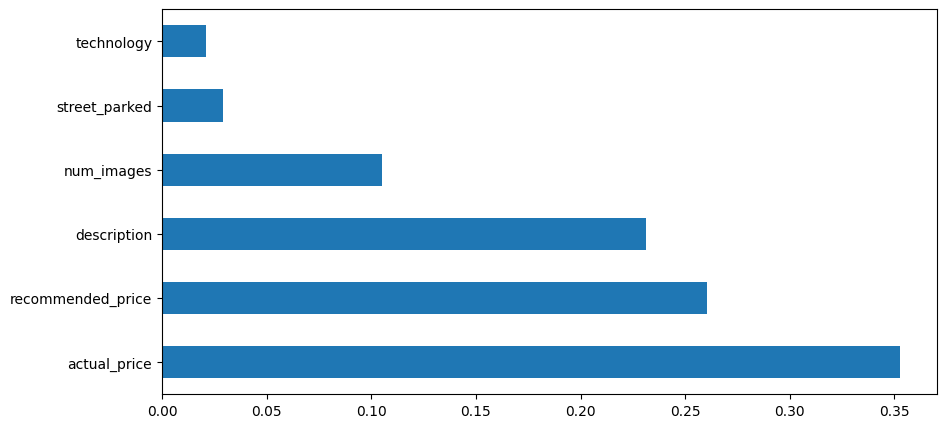

In [30]:
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')


🚀🚀🚀 **We can see that 'actual_price' is the most important factor.** 🚀🚀🚀